In [1]:

%matplotlib inline
%load_ext Cython

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cython
from pathlib import Path
from os.path import join
from IPython.display import display_markdown
import glob
import re
sns.set()
sns.set_palette('colorblind')
import tqdm

import platform

if platform.system() == 'Darwin':
    %config InlineBackend.figure_format = 'retina'


In [2]:
def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(path + '.gz', *args, **kwargs)
    except: 
        return pd.read_csv(path, *args, **kwargs)

In [3]:
condcond = 'nofake_see'
run = 0
path = "../../../logs/bm-alife-tp-allconf-method2-noclamp-2019-03-13-0*/"+condcond+"/**/rep00/"
logs = []
maxrun = 0
gen = 0
for curpath in tqdm.tqdm_notebook(sorted(glob.iglob(path, recursive=True))):
    try:
        if gen == 0:
            curgen = max([int(re.search('analysis_log_(\d+)', fname).group(1)) for fname in glob.glob(join(curpath, 'analysis_log_*'))])
        else:
            curgen = gen
        analyse_file = join(curpath, 'analysis_log_{}.txt'.format(curgen))
    except IndexError:
        print("Pas de resultat")
        continue
    except ValueError:
        print('pas de résultats')
        continue
   #print(analyse_file)
    log = read_csvx(analyse_file, delimiter="\t")
    log = log.query('oppCoop <= 10')
    log['run'] = run
    log['gen'] = int(curgen)
    log['onOpp'] = (log['oppId'] == 0)
    res = log.groupby(['oppNb', 'oppCoop', 'ind'], as_index=False).mean()
    res['run'] = run
    logs.append(res)
    run += 1
    if maxrun != 0 and run >= maxrun:
        print(f'max run ({maxrun}) to process is reached, change me if not intentionnal')
        break
log = pd.concat(logs)
import gc
gc.collect()
print('fini');



fini


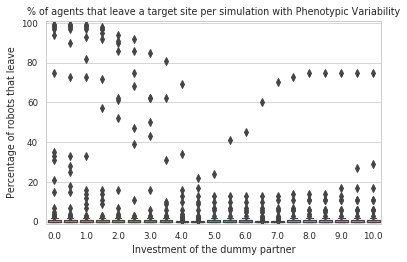

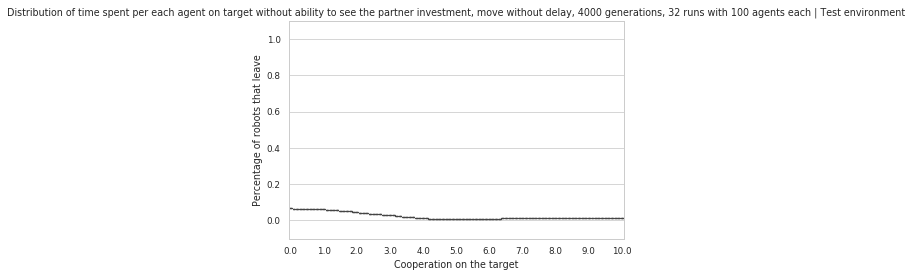

In [4]:
sns.set_context('paper')
sns.set_style('whitegrid')
#sns.stripplot(y='teleport', x='oppCoop', data=log.query('oppNb == 1').groupby(['oppNb', 'oppCoop', 'run'], as_index=False).mean(), cut=0, scale="width")

plt.figure(figsize=(6, 6/1.61))
sns.boxplot(y='teleport', x='oppCoop', data=log.query('oppNb == 1 and oppCoop % 0.5 == 0').groupby(['oppNb', 'oppCoop', 'run'], as_index=False).mean() * 100)
plt.title('% of agents that leave a target site per simulation with Phenotypic Variability')
plt.ylabel('Percentage of robots that leave')
plt.xlabel('Investment of the dummy partner')
plt.xticks(np.arange(0, 11/0.5, 2), np.arange(0, 10.5, 1))
plt.ylim(-1, 101);
#plt.tight_layout()
plt.savefig(f'Results/satisficing_{condcond}.pdf', bbox_inches = "tight")
plt.show()

plt.figure()
sns.boxplot(y='teleport', x='oppCoop', data=log.query('oppNb == 1').groupby(['oppNb', 'oppCoop'], as_index=False).mean())
plt.title('Distribution of time spent per each agent on target without ability to see the partner investment, move without delay, 4000 generations, 32 runs with 100 agents each | Test environment')
plt.ylabel('Percentage of robots that leave')
plt.xlabel('Cooperation on the target')
plt.xticks(np.arange(0, 101, 10), np.linspace(0, 10, 11))
plt.ylim(-0.1, 1.1);
plt.show()

if False:
    for run in log['run'].unique():
        plt.figure()
        sns.stripplot(y='teleport', x='oppCoop', data=log.query(f'oppNb == 1 and run == {run}').groupby(['oppNb', 'oppCoop', 'run'], as_index=False).mean())
        plt.title('Distribution of time spent per each agent on target without ability to see the partner investment, move without delay, 4000 generations, 32 runs with 100 agents each | Test environment')
        plt.ylabel('% de temps sur la cible')
        plt.xlabel('Coopération sur la cible')
        plt.xticks(np.arange(0, 101, 10), np.linspace(0, 10, 11))
        plt.ylim(-0.1, 1.1);
        plt.show();

In [ ]:
if False:
    sns.distplot(log.query('oppCoop == 6 and oppNb == 1')['ownCoop'], kde=False)
    plt.title('CMA-ES, téléportation, 20000 iterations par eval | Environnement test')
    plt.ylabel('coop de l\'agent')
    plt.xlabel('nb agent sur la cible')
    plt.axvline(2.5, c="r", label="ESS")
    plt.axvline(6.5, c="b", label="SO")
    plt.xlim(-0.1, 10.1)
    plt.legend()


In [40]:
log.query('oppCoop == 6.5')['ownCoop']

6499      5.956730
6500      5.956730
6501      5.239400
6502      5.239400
6503      5.956730
6504      5.239400
6505      5.956730
6506      6.131450
6507      5.956730
6508      5.956730
6509      5.956730
6510      5.956730
6511      3.759770
6512      5.956730
6513      5.956730
6514      5.239400
6515      5.239400
6516      5.239400
6517      5.239400
6518      5.956730
6519      5.956730
6520      5.956730
6521      5.956730
6522      5.956730
6523      5.956730
6524      1.257820
6525      5.956730
6526      5.956730
6527      5.956730
6528      5.956730
            ...   
147969    2.304080
147970    2.304080
147971    2.452260
147972    2.304080
147973    2.304080
147974    2.304080
147975    2.304080
147976    2.304080
147977    2.304080
147978    2.304080
147979    2.304080
147980    2.304080
147981    0.460962
147982    2.452260
147983    2.304080
147984    2.304080
147985    1.862020
147986    2.452260
147987    2.304080
147988    2.304080
147989    2.304080
147990    2.

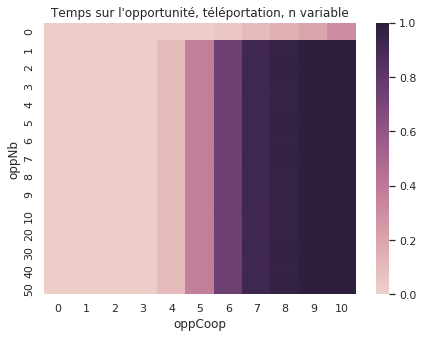

In [188]:
heatmap = pd.pivot_table(data=log, values='onOpp', index=['oppNb'], columns=['oppCoop'], aggfunc=np.mean)
plt.figure(figsize=(7, 5))
plt.title('Temps sur l\'opportunité, téléportation, n variable')
sns.heatmap(heatmap, cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=1);

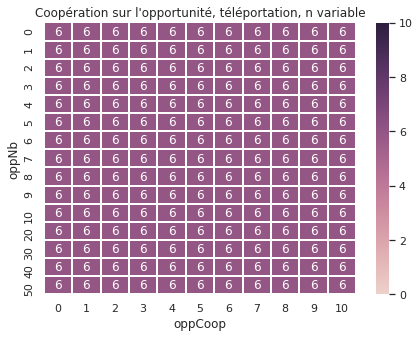

In [189]:
sns.set_context('notebook')
heatmap = pd.pivot_table(data=log, values='ownCoop', index=['oppNb'], columns=['oppCoop'], aggfunc=np.mean)
plt.figure(figsize=(7, 5))
plt.title('Coopération sur l\'opportunité, téléportation, n variable')
sns.heatmap(heatmap, cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=10, annot=True, linewidths=1);

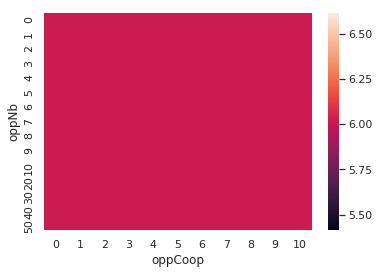

In [190]:
sns.heatmap(heatmap)

In [191]:
heatmap = pd.pivot_table(data=log, values='ownCoop', index=['oppNb'], columns=['oppCoop'], aggfunc=np.mean)


In [192]:
pd.pivot_table(data=log, values='ownCoop', index=['oppNb'], columns=['oppCoop'])

oppCoop,0,1,2,3,4,5,6,7,8,9,10
oppNb,,,,,,,,,,,
0,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
1,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
2,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
3,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
4,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
5,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
6,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
7,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104
8,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104,6.014104


log

In [24]:
run = 0
path = "/home/pecoffet/remotedata/bm-nvar-tp-2019-01-10-1712/**/run_09/rep00/"
logs = []
for curpath in sorted(glob.iglob(path, recursive=True)):
    analyse_file = sorted(glob.glob(curpath + 'analysis_log_*'), reverse=True)[0]
    print(analyse_file)
    log = read_csvx(analyse_file, delimiter="\t")
    log['run'] = run
    log['onOpp'] = (log['oppId'] == 0)
    res = log.groupby(['oppNb', 'oppCoop'], as_index=False).mean()
    res['run'] = run
    logs.append(res)
    run += 1
log2 = pd.concat(logs)

ValueError: No objects to concatenate

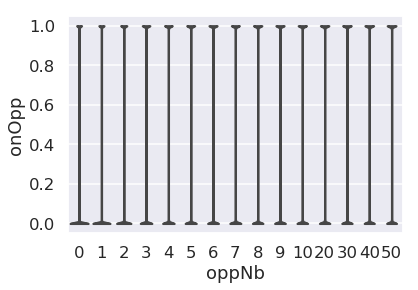

In [36]:
sns.violinplot(data=log.query('oppCoop == 3'), x='oppNb', y='onOpp', cut=0, bw=0.01, inner=None)

Text(0.5,1,'% de temps passé en moyenne par tous les individus avec une coopération = 3')

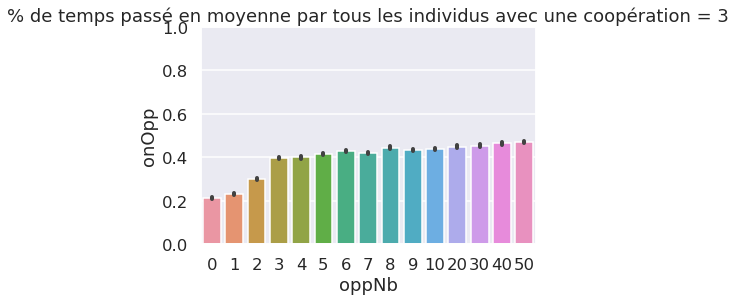

In [40]:
oppCoop = 3
sns.barplot(data=log.query(f'oppCoop == {oppCoop}'), x='oppNb', y='onOpp')
plt.ylim(0, 1)
plt.title(f'% de temps passé en moyenne par tous les individus avec une coopération = {oppCoop}')

Text(0.5,1,'% de temps passé en moyenne par tous les individus avec une coopération = 10')

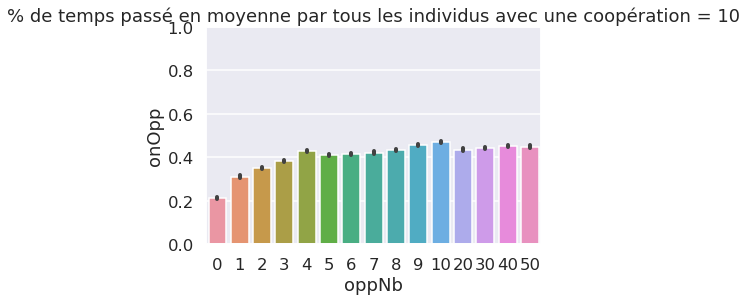

In [42]:
oppCoop = 10
sns.barplot(data=log.query(f'oppCoop == {oppCoop}'), x='oppNb', y='onOpp')
plt.ylim(0, 1)
plt.title(f'% de temps passé en moyenne par tous les individus avec une coopération = {oppCoop}')